# Wstęp

Niniejsze sprawozdanie zawiera opis i wyniki wykonania zadania domowego #2: **Optymalizacja eliminacji Gaussa**
z przedmiotu Optymalizacja kodu na różne architektury (OKNRA).

**Wykonał**: Danylo Knapp

**Numer albumu**: 414137

# Dane techniczne

## Maszyna lokalna

```bash
uname -a
Linux congard-fedora 6.8.9-200.fc39.x86_64 #1 SMP PREEMPT_DYNAMIC Thu May  2 18:44:19 UTC 2024 x86_64 GNU/Linux
```

### CPU

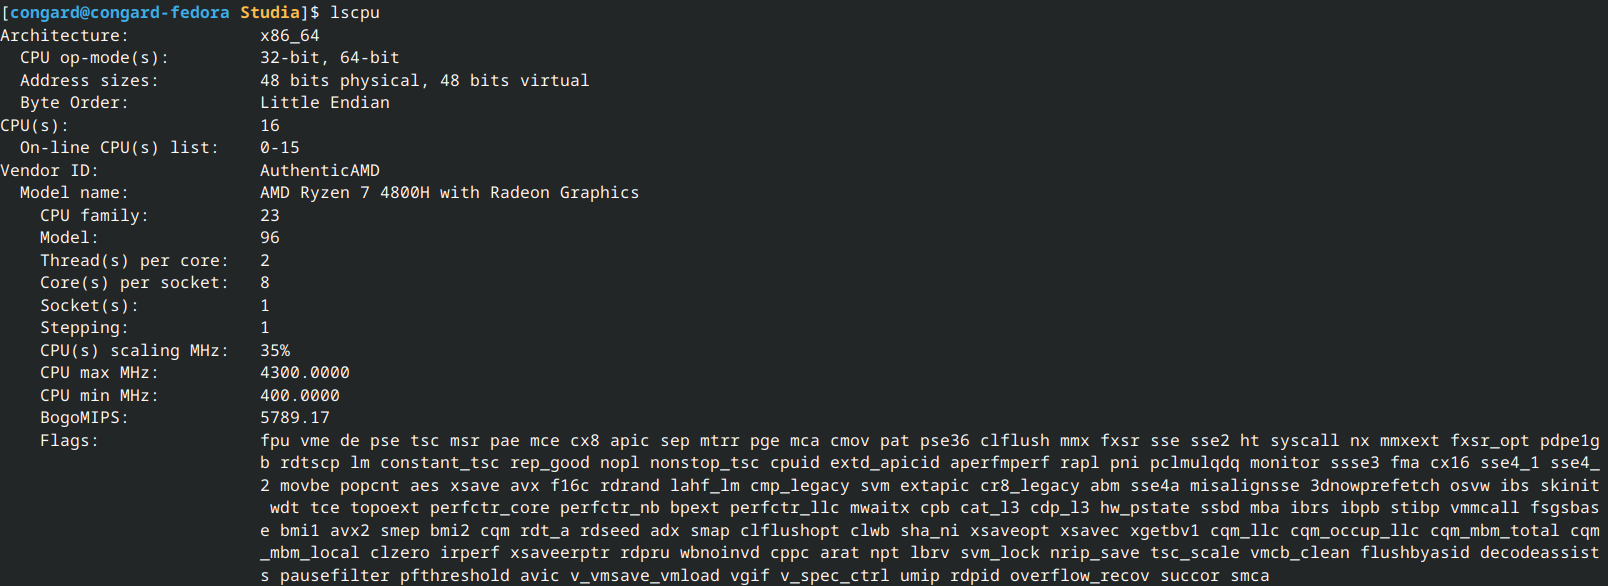

Jak wynika z powyższych informacji, mój procesor nie wspiera AVX-512. 

Wspierane liczniki procesora:

```
[congard@congard-fedora Studia]$ papi_avail | grep Yes
PAPI_L1_ICM  0x80000001  Yes   No   Level 1 instruction cache misses
PAPI_L2_DCM  0x80000002  Yes   No   Level 2 data cache misses
PAPI_L2_ICM  0x80000003  Yes   No   Level 2 instruction cache misses
PAPI_TLB_DM  0x80000014  Yes   No   Data translation lookaside buffer misses
PAPI_TLB_IM  0x80000015  Yes   Yes  Instruction translation lookaside buffer misses
PAPI_BR_TKN  0x8000002c  Yes   No   Conditional branch instructions taken
PAPI_BR_MSP  0x8000002e  Yes   No   Conditional branch instructions mispredicted
PAPI_TOT_INS 0x80000032  Yes   No   Instructions completed
PAPI_FP_INS  0x80000034  Yes   No   Floating point instructions
PAPI_BR_INS  0x80000037  Yes   No   Branch instructions
PAPI_TOT_CYC 0x8000003b  Yes   No   Total cycles
PAPI_L2_DCH  0x8000003f  Yes   No   Level 2 data cache hits
PAPI_L1_DCA  0x80000040  Yes   No   Level 1 data cache accesses
PAPI_L2_DCR  0x80000044  Yes   No   Level 2 data cache reads
PAPI_L2_ICH  0x8000004a  Yes   No   Level 2 instruction cache hits
PAPI_L2_ICR  0x80000050  Yes   No   Level 2 instruction cache reads
PAPI_FP_OPS  0x80000066  Yes   No   Floating point operations
```

Uwaga: avx512 zostanie przetestowane na bastionie (ale bez pomiaru flopsów)

## Kompilator

Podczas kompilacji optymalizacji **ge1-ge7** użyto kompilatora clang:

```
[congard@congard-fedora Studia]$ clang --version
clang version 17.0.6 (Fedora 17.0.6-2.fc39)
Target: x86_64-redhat-linux-gnu
Thread model: posix
InstalledDir: /usr/bin
```

## Bastion

```bash
uname -a
Linux dc1a-lab-oknra.ipa.ki.agh.edu.pl 4.18.0-553.5.1.el8_10.x86_64 #1 SMP Wed Jun 5 09:12:13 EDT 2024 x86_64 x86_64 x86_64 GNU/Linux
```

### CPU

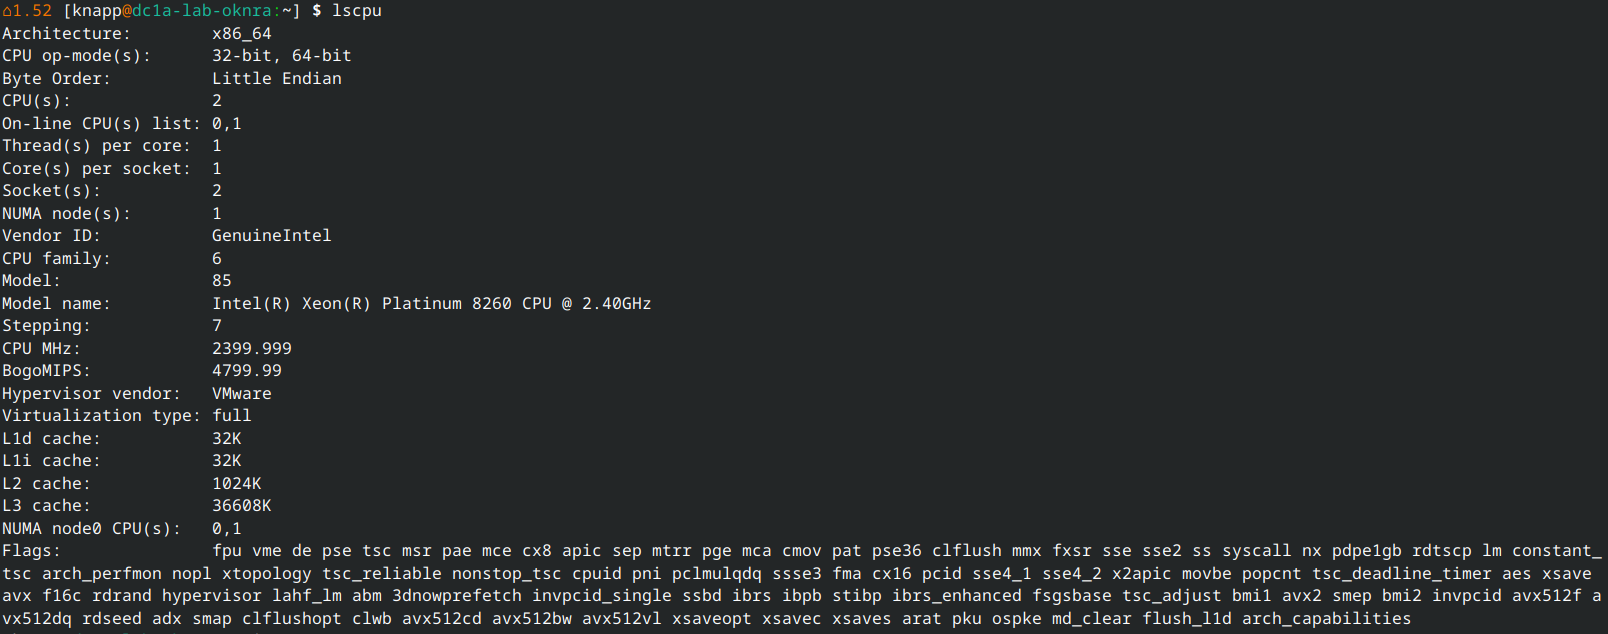

Jak wynika z powyższych informacji, dany procesor ma wsparcie AVX-512.

### Kompilator

Podczas kompilacji na bastionie optymalizacji **ge3**, **ge7** i **ge8** użyto kompilatora gcc:

```
[knapp@dc1a-lab-oknra:~] 127 $ gcc --version
gcc (GCC) 8.5.0 20210514 (Red Hat 8.5.0-22)
Copyright (C) 2018 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
```

# Wykonanie pomiarów

W celu wykonania pomiarów zostały przygotowane dodatkowe funkcje, uruchamiające odpowiednie testy i wypisujące wyniki.
Na przykład, uruchomienie wszystkich benchmarków wygląda w sposób następujący:

```c
#define RUN_BENCH(name) do { \
    printf("Starting benchmark: " #name "\n"); \
    run_bench(name, ge, size, dim);            \
    printf("\n"); \
} while (0)

static void benchmark(ge_t ge, int size, MatDim_t dim) {
    RUN_BENCH(benchmark_time);
    RUN_BENCH(benchmark_flops);
    RUN_BENCH(benchmark_ins_cyc);
    RUN_BENCH(benchmark_cond_taken_mispred);
}
```

gdzie `gt_t` - funkcja wykonująca eliminację Gaussa.

Benchmarkowanie z użyciem PAPI wygląda w sposób następujący:

```c
static void benchmark_ins_cyc(ge_t ge, void *mat, int size) {
    int event_codes[2] = {PAPI_TOT_INS, PAPI_TOT_CYC};
    long long values[2];

    papi_run(ge, mat, size, event_codes, 2, values);

    printf("Total instructions executed: %lld\nTotal cycles: %lld\n", values[0], values[1]);
}
```

gdzie `papi_run` - funkcja, wykonująca pomiary liczników `event_codes` i zapisująca wyniki do `values`.

## Użyte flagi

We wszystkich przypadkach, użyto następujących flag:

- `-march=native` - dopasowanie do własnej architektury
- `-O2` - *domyślnie jest `-O0`, czyli bez żadnych optymalizacji*
- `-mavx` (`-mavx512f` w przypadku bastionu)

## Macierz

Rozmiar macierzy we wszystkich przypadkach jest ustawiony na `1500`.

## Mierzone liczniki

- `PAPI_FP_OPS` - FLOPS (oprócz bastionu, gdzie ten licznik nie jest wspierany)
- `PAPI_TOT_INS` - liczba instrukcji
- `PAPI_TOT_CYC` - liczba cykli
- `PAPI_BR_TKN` - liczba instrukcji warunkowych
- `PAPI_BR_MSP` - liczba instrukcji warunkowych, niepoprawnie przewidzianych

# Pomiary

W tym rozdziale zostaną omówione poszczególne optymalizacje oraz zostaną przedstawione wyniki.

## Maszyna lokalna

### ge1

Wersja bez optymalizacji.

```bash
Starting benchmark: benchmark_time
Starting benchmarking...
Benchmarking time...
Time: 1.505726e+00 sec
Check: -4.605781e+16 

Starting benchmark: benchmark_flops
Starting benchmarking...
Benchmarking flops...
Real_time: 1.504705
Proc_time: 1.504604
flpops: 3371625750
MFLOPS: 2240.872559
Check: -4.605781e+16 

Starting benchmark: benchmark_ins_cyc
Starting benchmarking...
Total instructions executed: 8997765703
Total cycles: 6347900856
Check: -4.605781e+16 

Starting benchmark: benchmark_cond_taken_mispred
Starting benchmarking...
Conditional branch instructions taken: 1123876835
Conditional branch instructions mispredicted: 1134511
Check: -4.605781e+16 
```

### ge2

Liczniki pętli zostały umieszczone w rejestrach.

```bash
Starting benchmark: benchmark_time
Starting benchmarking...
Benchmarking time...
Time: 1.527838e+00 sec
Check: -4.605781e+16 

Starting benchmark: benchmark_flops
Starting benchmarking...
Benchmarking flops...
Real_time: 1.510554
Proc_time: 1.510518
flpops: 3371625750
MFLOPS: 2232.099121
Check: -4.605781e+16 

Starting benchmark: benchmark_ins_cyc
Starting benchmarking...
Total instructions executed: 8997766009
Total cycles: 6380764740
Check: -4.605781e+16 

Starting benchmark: benchmark_cond_taken_mispred
Starting benchmarking...
Conditional branch instructions taken: 1123876922
Conditional branch instructions mispredicted: 1134107
Check: -4.605781e+16
```

Jak widać, nie ma prawie żadnej różnicy w porównaniu z poprzednim wynikiem, co mówi o tym,
że w poprzednim przypadku kompilator już to zoptymalizował samodzielnie.

### ge3

W rejestrze została umieszczona powtarzającą się w najbardziej zagnieżdżonym
miejscu wartość, czyli:

```c
multiplier = (A[i][k]/A[k][k]);
```

Wynik:

```bash
Starting benchmark: benchmark_time
Starting benchmarking...
Benchmarking time...
Time: 7.626570e-01 sec
Check: -4.605781e+16 

Starting benchmark: benchmark_flops
Starting benchmarking...
Benchmarking flops...
Real_time: 0.761170
Proc_time: 0.759529
flpops: 2248874750
MFLOPS: 2960.880615
Check: -4.605781e+16 

Starting benchmark: benchmark_ins_cyc
Starting benchmarking...
Total instructions executed: 1119811406
Total cycles: 3261152374
Check: -4.605781e+16 

Starting benchmark: benchmark_cond_taken_mispred
Starting benchmarking...
Conditional branch instructions taken: 78217265
Conditional branch instructions mispredicted: 44795
Check: -4.605781e+16 
```

Jak widać w powyższego wyniku, mamy 2 krotne przyspieszenie w porównaniu z poprzednimi wynikami.

### ge4

Najbardziej zagnieżdżona pętla została rozwinięta do 8 iteracji.

```bash
Starting benchmark: benchmark_time
Starting benchmarking...
Benchmarking time...
Time: 1.025453e+00 sec
Check: -4.605781e+16 

Starting benchmark: benchmark_flops
Starting benchmarking...
Benchmarking flops...
Real_time: 1.037115
Proc_time: 1.037027
flpops: 2248874750
MFLOPS: 2168.578857
Check: -4.605781e+16 

Starting benchmark: benchmark_ins_cyc
Starting benchmarking...
Total instructions executed: 5099311209
Total cycles: 4176920414
Check: -4.605781e+16 

Starting benchmark: benchmark_cond_taken_mispred
Starting benchmarking...
Conditional branch instructions taken: 147160767
Conditional branch instructions mispredicted: 867175
Check: -4.605781e+16 
```

Czasowo jest gorzej niż w poprzednim przypadku. Ale czy to jest źle? Nie, bo to zostało zrobione w celu
umożliwienia wykonania dalszych optymalizacji.

### ge5

Macierz dwuwymiarowa została zamieniona na macierz jednowymiarową indeksowaną przez macro.

```bash
Starting benchmark: benchmark_time
Starting benchmarking...
Benchmarking time...
Time: 1.060818e+00 sec
Check: -4.605781e+16 

Starting benchmark: benchmark_flops
Starting benchmarking...
Benchmarking flops...
Real_time: 1.094921
Proc_time: 1.090934
flpops: 2248874750
MFLOPS: 2061.421387
Check: -4.605781e+16 

Starting benchmark: benchmark_ins_cyc
Starting benchmarking...
Total instructions executed: 7204409530
Total cycles: 4327164810
Check: -4.605781e+16 

Starting benchmark: benchmark_cond_taken_mispred
Starting benchmarking...
Conditional branch instructions taken: 147160798
Conditional branch instructions mispredicted: 877104
Check: -4.605781e+16 
```

Czasowo - bez zmian.

### ge6

Zostały wprowadzone operacje wektorowe SSE3.

```bash
Starting benchmark: benchmark_time
Starting benchmarking...
Benchmarking time...
Time: 9.591380e-01 sec
Check: -4.605781e+16 

Starting benchmark: benchmark_flops
Starting benchmarking...
Benchmarking flops...
Real_time: 0.946750
Proc_time: 0.946701
flpops: 2248874750
MFLOPS: 2375.485840
Check: -4.605781e+16 

Starting benchmark: benchmark_ins_cyc
Starting benchmarking...
Total instructions executed: 4698871313
Total cycles: 3979664139
Check: -4.605781e+16 

Starting benchmark: benchmark_cond_taken_mispred
Starting benchmarking...
Conditional branch instructions taken: 147160696
Conditional branch instructions mispredicted: 897919
Check: -4.605781e+16
```

Jest lepiej, ale nie jest to specjalnie zauważalne.

### ge7

Zostały wprowadzone 256-bitowe operacje wektorowe AVX.

```bash
Starting benchmark: benchmark_time
Starting benchmarking...
Benchmarking time...
Time: 8.824810e-01 sec
Check: -4.605781e+16 

Starting benchmark: benchmark_flops
Starting benchmarking...
Benchmarking flops...
Real_time: 0.867856
Proc_time: 0.867736
flpops: 2248874750
MFLOPS: 2591.657715
Check: -4.605781e+16 

Starting benchmark: benchmark_ins_cyc
Starting benchmarking...
Total instructions executed: 3015016248
Total cycles: 3670233743
Check: -4.605781e+16 

Starting benchmark: benchmark_cond_taken_mispred
Starting benchmarking...
Conditional branch instructions taken: 147160652
Conditional branch instructions mispredicted: 866772
Check: -4.605781e+16 
```

Czasowo jest lepiej, ale wciąż jest gorzej niż w przypadku **ge3**.

### Podsumowanie

W przypadku maszyny lokalnej, najlepszą optymalizacją okazała się optymalizacja **ge3**.

## Bastion

### ge3

```bash
gcc ge3.c benchmark.c \
    $(pkg-config --cflags --libs papi) \
    -lm -O2 -DMAT_SIZE=1500 -o ge3 && ./ge3

Starting benchmark: benchmark_time
Starting benchmarking...
Benchmarking time...
Time: 7.848650e-01 sec
Check: -4.605781e+16 

Starting benchmark: benchmark_ins_cyc
Starting benchmarking...
Total instructions executed: 9000008952
Total cycles: 2343783760
Check: -4.605781e+16 

Starting benchmark: benchmark_cond_taken_mispred
Starting benchmarking...
Conditional branch instructions taken: 1123875279
Conditional branch instructions mispredicted: 1123546
Check: -4.605781e+16
```

### ge7

```bash
gcc ge7.c benchmark.c \
    $(pkg-config --cflags --libs papi) \
    -lm -O2 -mavx -DMAT_SIZE=1500 -o ge7 && ./ge7

Starting benchmark: benchmark_time
Starting benchmarking...
Benchmarking time...
Time: 6.307870e-01 sec
Check: -4.605781e+16 

Starting benchmark: benchmark_ins_cyc
Starting benchmarking...
Total instructions executed: 5002186579
Total cycles: 1607707368
Check: -4.605781e+16 

Starting benchmark: benchmark_cond_taken_mispred
Starting benchmarking...
Conditional branch instructions taken: 144906716
Conditional branch instructions mispredicted: 1000737
Check: -4.605781e+16
```

Wniosek: jest lepiej, niż w przypadku optymalizacji **ge3**.

### ge8

Zostały wprowadzone 512-bitowe operacje wektorowe AVX.

```bash
gcc ge8.c benchmark.c \
    $(pkg-config --cflags --libs papi) \
    -lm -O2 -mavx512f -DMAT_SIZE=1500 -o ge8 && ./ge8

Starting benchmark: benchmark_time
Starting benchmarking...
Benchmarking time...
Time: 4.825540e-01 sec
Check: -4.605781e+16 

Starting benchmark: benchmark_ins_cyc
Starting benchmarking...
Total instructions executed: 1917559472
Total cycles: 1082019997
Check: -4.605781e+16 

Starting benchmark: benchmark_cond_taken_mispred
Starting benchmarking...
Conditional branch instructions taken: 79190832
Conditional branch instructions mispredicted: 434740
Check: -4.605781e+16
```

Wniosek: lepiej niż poprzednio

### Podsumowanie

W przypadku bastionu, najlepszą optymalizacją okazała się optymalizacja **ge8**.

# Wykresy

W tym rozdziale zostaną przedstawione wykresy dla poszczególnych pomiarów.

## Maszyna lokalna

### Time

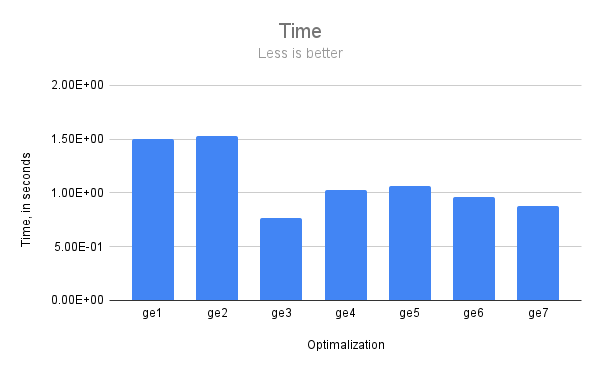

### MFLOPS

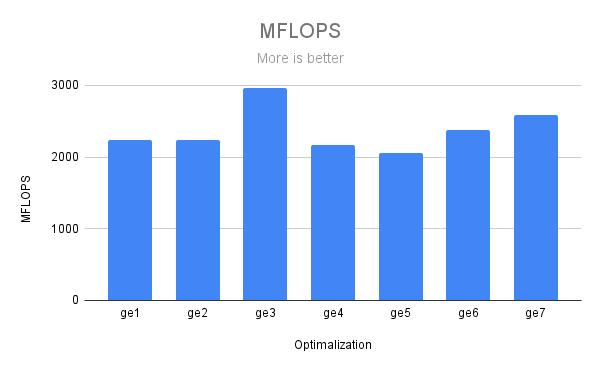

### Total instructions

![Total instructions-2.png](<attachment:Total instructions-2.png>)
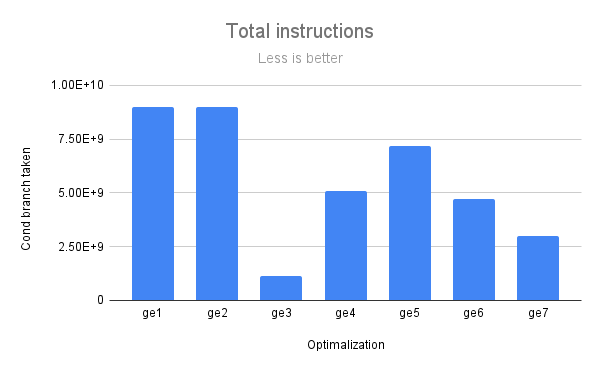

### Total cycles

![Total cycles-2.png](<attachment:Total cycles-2.png>)
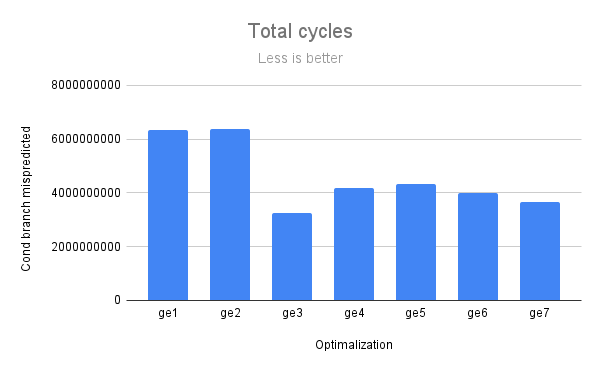

### Conditional branch taken

![Conditional branch taken-2.png](<attachment:Conditional branch taken-2.png>)
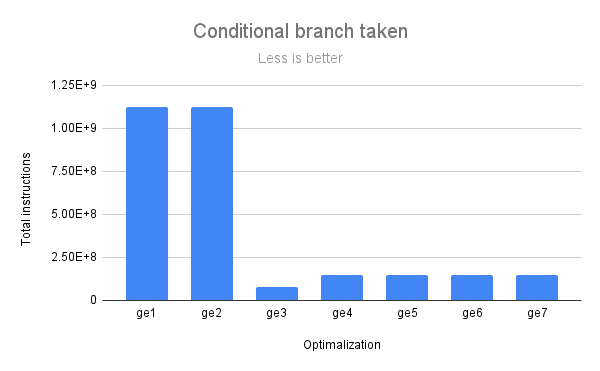

### Conditional branch mispredicted

![Conditional branch mispredicted-2.png](<attachment:Conditional branch mispredicted-2.png>)
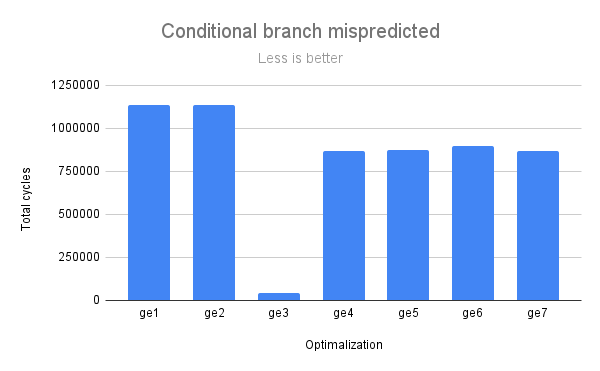

## Bastion

### Time

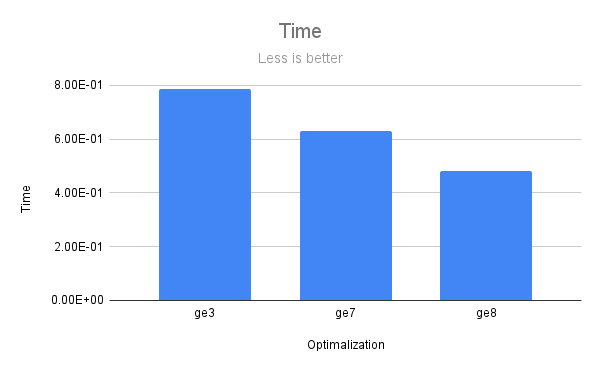

### Total instructions

![Total instructions_bastion-2.png](<attachment:Total instructions_bastion-2.png>)
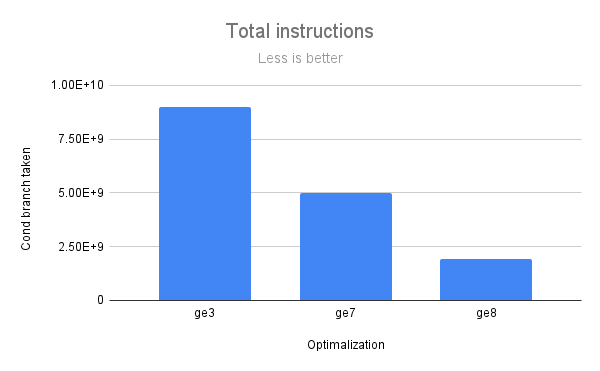

### Total cycles

![Total cycles_bastion-2.png](<attachment:Total cycles_bastion-2.png>)
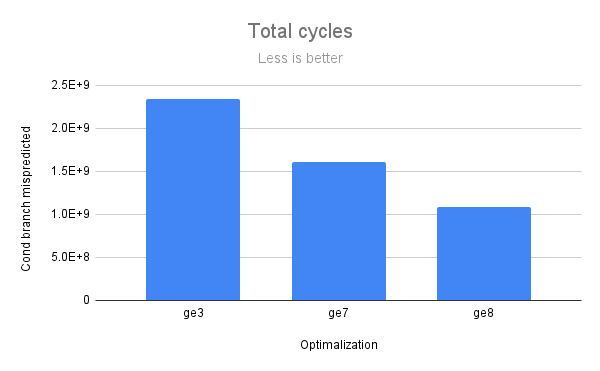

### Conditional branch taken

![Conditional branch taken_bastion-2.png](<attachment:Conditional branch taken_bastion-2.png>)
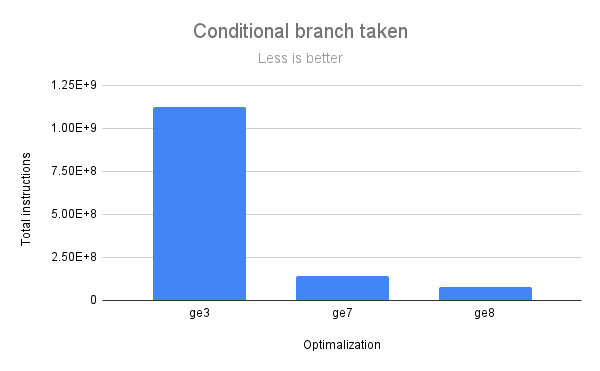

### Conditional branch mispredicted

![Conditional branch mispredicted_bastion-2.png](<attachment:Conditional branch mispredicted_bastion-2.png>)
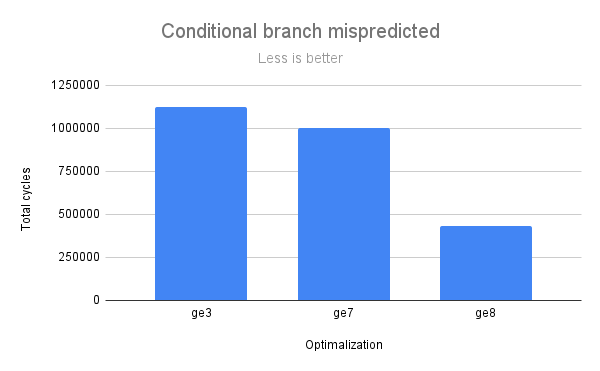

# Wnioski

- W przypadku maszyny lokalnej, najlepszą optymalizacją okazała się optymalizacja **ge3**;
- W przypadku bastionu, najlepszą optymalizacją, zgodnie z oczekiwaniami, okazała się optymalizacja **ge8**;
- Nie wszystkie współczesne procesory wspierają AVX-512, co jest zwłaszcza zauważalne w przypadku procesorów AMD:
  AVX-512 jest wspierane dopiero przez najnowocześniejsze mikroarchitektury Zen 4 oraz Zen 5.

# Źródła

1. Materiały do laboratorium 2 – dr hab. inż. Maciej Woźniak
2. Materiały do laboratorium 3 – dr hab. inż. Maciej Woźniak
3. Materiały do laboratorium 4 – dr hab. inż. Maciej Woźniak
4. How To Optimize Gemm – flame: [https://github.com/flame/how-to-optimize-gemm](https://github.com/flame/how-to-optimize-gemm)
5. AVX-512 – Wikipedia: [https://en.wikipedia.org/wiki/AVX-512](https://en.wikipedia.org/wiki/AVX-512)